In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. MINIMAL CNN - Ultra-simple baseline

In [ ]:
class MinimalCNN(nn.Module):
    """
    Very simple 3-layer CNN with minimal parameters
    ~15K parameters
    """
    def __init__(self, num_classes=10):
        super(MinimalCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)  # 32x32 -> 32x32
        self.pool = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)  # 16x16 -> 16x16
        # After second pool: 8x8
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 8x8 -> 8x8
        # After third pool: 4x4
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# 2. NARROW DEEP CNN - Small width, more depth

In [ ]:
class NarrowDeepCNN(nn.Module):
    """
    Narrow but deeper network - testing depth vs width
    ~25K parameters
    """
    def __init__(self, num_classes=10):
        super(NarrowDeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # 16x16
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)  # 8x8
        x = F.relu(self.conv5(x))
        x = self.pool(x)  # 4x4
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# 3. WIDE SHALLOW CNN - More width, less depth

In [ ]:
class WideShallowCNN(nn.Module):
    """
    Wide but shallow network - testing width vs depth
    ~50K parameters
    """
    def __init__(self, num_classes=10):
        super(WideShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 4. SMALL KERNEL CNN - Using 1x1 and 3x3 kernels only

In [ ]:
class SmallKernelCNN(nn.Module):
    """
    Using only small kernels (1x1, 3x3) - inspired by modern architectures
    ~30K parameters
    """
    def __init__(self, num_classes=10):
        super(SmallKernelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1_1x1 = nn.Conv2d(32, 32, kernel_size=1)  # 1x1 conv
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_1x1 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_1x1(x))
        x = self.pool(x)  # 16x16
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_1x1(x))
        x = self.pool(x)  # 8x8
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 5. LARGE KERNEL CNN - Using larger kernels

In [ ]:
class LargeKernelCNN(nn.Module):
    """
    Using larger kernels (7x7, 5x5) - more receptive field per layer
    ~40K parameters
    """
    def __init__(self, num_classes=10):
        super(LargeKernelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 6. DROPOUT HEAVY CNN - High regularization

In [ ]:
class DropoutHeavyCNN(nn.Module):
    """
    Same architecture as WideShallowCNN but with heavy dropout
    Testing if regularization affects backdoor susceptibility
    """
    def __init__(self, num_classes=10):
        super(DropoutHeavyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout_conv = nn.Dropout2d(0.2)  # Spatial dropout
        self.dropout_fc = nn.Dropout(0.7)     # Heavy dropout

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# 7. AVGPOOL CNN - Using Average Pooling instead of Max Pooling - train this model and check if it learns things (you can do it on cifar10), train normal, train with attacks, and then with exit layers just train with badnet

and after that we try with different pooling

In [ ]:
  class AvgPoolCNN(nn.Module):
    """
    Testing average pooling vs max pooling
    ~35K parameters
    """
    def __init__(self, num_classes=10):
        super(AvgPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.avgpool = nn.AvgPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.avgpool(F.relu(self.conv1(x)))  # 16x16
        x = self.avgpool(F.relu(self.conv2(x)))  # 8x8
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)  # 1x1
        x = x.view(-1, 256)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

# ========== Model ==========
class AvgPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AvgPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.avgpool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AvgPoolCNN(num_classes=10).to(device)
EPOCHS = 30

SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_PATH = os.path.join(SAVE_DIR, "avgpoolcnn_cifar10_clean.pth")

# CIFAR-10 Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ========== Trackers ==========
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# ========== Training ==========
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_loss /= total
    train_acc = 100 * correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Evaluate on test (val) set
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    val_loss /= total
    val_acc = 100 * correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== Save ==========
torch.save(model.state_dict(), SAVE_PATH)
print(f"\n Model saved to: {SAVE_PATH}")

# ========== Plot ==========
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


100%|██████████| 170M/170M [00:02<00:00, 66.8MB/s]


Epoch 1/30 | Train Loss: 1.7423 | Train Acc: 34.00% | Val Loss: 1.5322 | Val Acc: 44.14%
Epoch 2/30 | Train Loss: 1.4249 | Train Acc: 47.80% | Val Loss: 1.3052 | Val Acc: 52.21%
Epoch 3/30 | Train Loss: 1.2609 | Train Acc: 54.37% | Val Loss: 1.1521 | Val Acc: 58.29%
Epoch 4/30 | Train Loss: 1.1441 | Train Acc: 58.89% | Val Loss: 1.0701 | Val Acc: 61.37%
Epoch 5/30 | Train Loss: 1.0465 | Train Acc: 62.59% | Val Loss: 1.0431 | Val Acc: 62.26%
Epoch 6/30 | Train Loss: 0.9726 | Train Acc: 65.55% | Val Loss: 0.9478 | Val Acc: 66.74%
Epoch 7/30 | Train Loss: 0.9119 | Train Acc: 67.61% | Val Loss: 0.8716 | Val Acc: 69.05%
Epoch 8/30 | Train Loss: 0.8598 | Train Acc: 69.56% | Val Loss: 0.8405 | Val Acc: 70.36%
Epoch 9/30 | Train Loss: 0.8145 | Train Acc: 71.08% | Val Loss: 0.8205 | Val Acc: 71.34%
Epoch 10/30 | Train Loss: 0.7756 | Train Acc: 72.68% | Val Loss: 0.7872 | Val Acc: 72.71%
Epoch 11/30 | Train Loss: 0.7342 | Train Acc: 74.19% | Val Loss: 0.7639 | Val Acc: 73.25%
Epoch 12/30 | Train

KeyboardInterrupt: 

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments/avgpoolcnn_cifar10_clean.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f" Model saved after early stop to: {SAVE_PATH}")

 Model saved after early stop to: /content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments/avgpoolcnn_cifar10_clean.pth


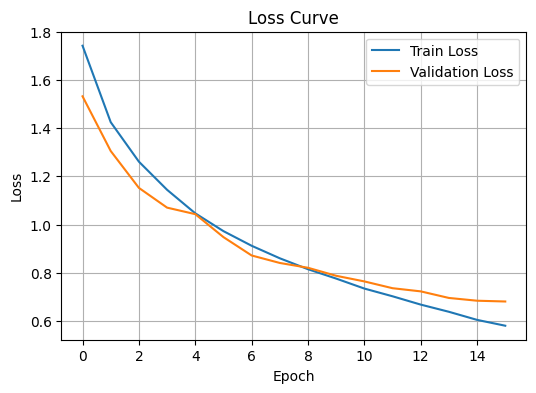

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


Both train and validation loss decrease steadily, there is no overfitting:, Val loss follows training loss closely
Epoch 1/30 | Train Loss: 1.7423 | Train Acc: 34.00% | Val Loss: 1.5322 | Val Acc: 44.14%
Epoch 2/30 | Train Loss: 1.4249 | Train Acc: 47.80% | Val Loss: 1.3052 | Val Acc: 52.21%
Epoch 3/30 | Train Loss: 1.2609 | Train Acc: 54.37% | Val Loss: 1.1521 | Val Acc: 58.29%
Epoch 4/30 | Train Loss: 1.1441 | Train Acc: 58.89% | Val Loss: 1.0701 | Val Acc: 61.37%
Epoch 5/30 | Train Loss: 1.0465 | Train Acc: 62.59% | Val Loss: 1.0431 | Val Acc: 62.26%
Epoch 6/30 | Train Loss: 0.9726 | Train Acc: 65.55% | Val Loss: 0.9478 | Val Acc: 66.74%
Epoch 7/30 | Train Loss: 0.9119 | Train Acc: 67.61% | Val Loss: 0.8716 | Val Acc: 69.05%
Epoch 8/30 | Train Loss: 0.8598 | Train Acc: 69.56% | Val Loss: 0.8405 | Val Acc: 70.36%
Epoch 9/30 | Train Loss: 0.8145 | Train Acc: 71.08% | Val Loss: 0.8205 | Val Acc: 71.34%
Epoch 10/30 | Train Loss: 0.7756 | Train Acc: 72.68% | Val Loss: 0.7872 | Val Acc: 72.71%
Epoch 11/30 | Train Loss: 0.7342 | Train Acc: 74.19% | Val Loss: 0.7639 | Val Acc: 73.25%
Epoch 12/30 | Train Loss: 0.7021 | Train Acc: 75.24% | Val Loss: 0.7357 | Val Acc: 74.37%
Epoch 13/30 | Train Loss: 0.6676 | Train Acc: 76.47% | Val Loss: 0.7225 | Val Acc: 74.85%
Epoch 14/30 | Train Loss: 0.6378 | Train Acc: 77.50% | Val Loss: 0.6952 | Val Acc: 76.02%
Epoch 15/30 | Train Loss: 0.6042 | Train Acc: 78.65% | Val Loss: 0.6837 | Val Acc: 76.18%
Epoch 16/30 | Train Loss: 0.5799 | Train Acc: 79.59% | Val Loss: 0.6805 | Val Acc: 76.37%

Training with badnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
from copy import deepcopy
import pandas as pd

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 1e-3
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

# ========== Set seed ==========
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Model ==========
class AvgPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AvgPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AvgPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.avgpool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# ========== Trigger & Poison ==========
def add_trigger(image, trigger_size=5, trigger_color=(1,1,1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3,1,1)
    return img

def poison_dataset(dataset, trigger_size=5, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_total = len(dataset_copy)
    n_poison = int(poison_fraction * n_total)
    poison_indices = random.sample(range(n_total), n_poison)

    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size=trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=5, target_class=0):
    triggered_samples = []
    for img, _ in dataset:
        img = add_trigger(img, trigger_size=trigger_size)
        triggered_samples.append((img, target_class))
    return triggered_samples

class PoisonedDataset(Dataset):
    def __init__(self, poisoned_samples, transform=None):
        self.poisoned_samples = poisoned_samples
        self.transform = transform

    def __len__(self):
        return len(self.poisoned_samples)

    def __getitem__(self, idx):
        img, label = self.poisoned_samples[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# ========== Evaluation ==========
def evaluate_clean_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    return 100 * correct / total

def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct_target += preds.eq(target_class).sum().item()
    return 100 * correct_target / total

# ========== Data ==========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_samples = poison_dataset(train_dataset, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
poisoned_dataset = PoisonedDataset(poisoned_samples)
poisoned_loader = DataLoader(poisoned_dataset, batch_size=BATCH_SIZE, shuffle=True)

clean_val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
triggered_testset = create_triggered_testset(test_dataset, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)
triggered_loader = DataLoader(PoisonedDataset(triggered_testset), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = AvgPoolCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, train_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in poisoned_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

# ========== Final Evaluation ==========
clean_acc = evaluate_clean_accuracy(model, clean_val_loader)
asr = evaluate_asr(model, triggered_loader, target_class=TARGET_CLASS)

print(f"\n Final Clean Accuracy: {clean_acc:.2f}%")
print(f" Final ASR: {asr:.2f}%")

# ========== Save ==========
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "avgpoolcnn_cifar10_badnet.pth"))
print(f"\n Model saved to {SAVE_DIR}/avgpoolcnn_cifar10_badnet.pth")


Epoch [1/15] - Train Loss: 1.7115 | Train Acc: 36.22%
Epoch [2/15] - Train Loss: 1.3178 | Train Acc: 51.76%
Epoch [3/15] - Train Loss: 1.1717 | Train Acc: 57.68%
Epoch [4/15] - Train Loss: 1.0537 | Train Acc: 62.27%
Epoch [5/15] - Train Loss: 0.9615 | Train Acc: 65.86%
Epoch [6/15] - Train Loss: 0.8901 | Train Acc: 68.43%
Epoch [7/15] - Train Loss: 0.8354 | Train Acc: 70.39%
Epoch [8/15] - Train Loss: 0.7902 | Train Acc: 72.13%
Epoch [9/15] - Train Loss: 0.7487 | Train Acc: 73.51%
Epoch [10/15] - Train Loss: 0.7173 | Train Acc: 74.47%
Epoch [11/15] - Train Loss: 0.6820 | Train Acc: 76.24%
Epoch [12/15] - Train Loss: 0.6531 | Train Acc: 77.07%
Epoch [13/15] - Train Loss: 0.6225 | Train Acc: 78.26%
Epoch [14/15] - Train Loss: 0.5945 | Train Acc: 79.11%
Epoch [15/15] - Train Loss: 0.5692 | Train Acc: 79.98%

 Final Clean Accuracy: 75.69%
 Final ASR: 98.38%

 Model saved to /content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments/avgpoolcnn_cifar10_badnet.pth


EENET for AVGPOOL MODEL

In [ ]:
class SmallExit(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SmallExit, self).__init__()
        self.exit = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_channels, num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.exit(x)

class AvgPoolEENet(nn.Module):
    def __init__(self, num_classes=10):
        super(AvgPoolEENet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.avgpool = nn.AvgPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

        # Early exits
        self.exit1 = SmallExit(64, num_classes)    # After conv2
        self.exit2 = SmallExit(128, num_classes)   # After conv3
        self.exit3 = SmallExit(256, num_classes)   # After conv4

    def forward(self, x):
        preds = []

        x = self.avgpool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        preds.append(self.exit1(x))

        x = F.relu(self.conv3(x))
        preds.append(self.exit2(x))

        x = F.relu(self.conv4(x))
        preds.append(self.exit3(x))

        x = self.global_avgpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        final_out = F.softmax(self.fc(x), dim=1)
        preds.append(final_out)

        return preds

##MinPool model training with badnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from copy import deepcopy
import os

# ====== Configuration ======
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ====== MinPoolCNN ======
class MinPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return -F.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

class MinPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.minpool = MinPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.minpool(F.relu(self.conv1(x)))
        x = self.minpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# ====== Poisoning Functions ======
def add_trigger(image, trigger_size=3, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, trigger_size=3, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset_copy))
    poison_indices = random.sample(range(len(dataset_copy)), n_poison)

    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=3, target_class=0):
    return [(add_trigger(img, trigger_size), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        return img, label

# ====== Load Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = MinPoolCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Final Evaluation ======
def evaluate_asr(model, loader, target_class):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Clean Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ====== Save Model ======
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "minpoolcnn_cifar10_badnet.pth"))
print(f"Model saved to: {os.path.join(SAVE_DIR, 'minpoolcnn_cifar10_badnet.pth')}")


100%|██████████| 170M/170M [00:02<00:00, 68.6MB/s]


Epoch 1/15 | Train Loss: 2.0829 | Train Acc: 21.40% | Val Loss: 1.9741 | Val Acc: 22.62%
Epoch 2/15 | Train Loss: 1.8966 | Train Acc: 27.93% | Val Loss: 1.8190 | Val Acc: 32.32%
Epoch 3/15 | Train Loss: 1.7998 | Train Acc: 32.16% | Val Loss: 1.7447 | Val Acc: 35.27%
Epoch 4/15 | Train Loss: 1.7472 | Train Acc: 34.57% | Val Loss: 1.7119 | Val Acc: 36.50%
Epoch 5/15 | Train Loss: 1.7042 | Train Acc: 36.56% | Val Loss: 1.6791 | Val Acc: 38.49%
Epoch 6/15 | Train Loss: 1.6734 | Train Acc: 37.58% | Val Loss: 1.6481 | Val Acc: 40.53%
Epoch 7/15 | Train Loss: 1.6537 | Train Acc: 38.37% | Val Loss: 1.5652 | Val Acc: 43.17%
Epoch 8/15 | Train Loss: 1.6263 | Train Acc: 39.73% | Val Loss: 1.5676 | Val Acc: 43.35%
Epoch 9/15 | Train Loss: 1.6082 | Train Acc: 40.30% | Val Loss: 1.5445 | Val Acc: 43.86%
Epoch 10/15 | Train Loss: 1.5943 | Train Acc: 40.63% | Val Loss: 1.5431 | Val Acc: 44.28%
Epoch 11/15 | Train Loss: 1.5773 | Train Acc: 41.75% | Val Loss: 1.5215 | Val Acc: 45.55%
Epoch 12/15 | Train

resuming training to train a bit more epochs

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"

# === Set seed ===
def set_seed(seed=13):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# === Define model again if needed ===
class MinPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
    def forward(self, x):
        return -F.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

class MinPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.minpool = MinPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.minpool(F.relu(self.conv1(x)))
        x = self.minpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# === Trigger logic ===
def add_trigger(image, trigger_size=3, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (img, label) in enumerate(dataset):
        if i in poison_indices:
            img = add_trigger(img)
            label = target_class
        poisoned.append((img, label))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(img), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples): self.samples = samples
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

# === Reload data loaders ===
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_dataset, poison_fraction=0.1, target_class=0)
triggered_test = create_triggered_testset(test_dataset, target_class=0)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=64, shuffle=False)

# === Load model and resume ===
model = MinPoolCNN(num_classes=10).to(device)
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "minpoolcnn_cifar10_badnet.pth")))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# === Resume training ===
for epoch in range(31, 50):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss /= total
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch}/50 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# === Evaluate ASR ===
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, target_class=0)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# === Save model again ===
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "minpoolcnn_cifar10_badnet.pth"))

Epoch 31/50 | Train Loss: 1.3201 | Train Acc: 52.23% | Val Loss: 1.2652 | Val Acc: 55.65%
Epoch 32/50 | Train Loss: 1.2932 | Train Acc: 53.41% | Val Loss: 1.2536 | Val Acc: 56.02%
Epoch 33/50 | Train Loss: 1.2629 | Train Acc: 55.04% | Val Loss: 1.2452 | Val Acc: 56.19%
Epoch 34/50 | Train Loss: 1.2357 | Train Acc: 56.17% | Val Loss: 1.2967 | Val Acc: 53.04%
Epoch 35/50 | Train Loss: 1.2046 | Train Acc: 57.31% | Val Loss: 1.2565 | Val Acc: 54.99%
Epoch 36/50 | Train Loss: 1.1814 | Train Acc: 58.35% | Val Loss: 1.2636 | Val Acc: 54.77%
Epoch 37/50 | Train Loss: 1.1604 | Train Acc: 58.75% | Val Loss: 1.2159 | Val Acc: 56.85%
Epoch 38/50 | Train Loss: 1.1390 | Train Acc: 59.46% | Val Loss: 1.1813 | Val Acc: 58.26%
Epoch 39/50 | Train Loss: 1.1265 | Train Acc: 59.96% | Val Loss: 1.1641 | Val Acc: 58.83%
Epoch 40/50 | Train Loss: 1.1137 | Train Acc: 60.28% | Val Loss: 1.1661 | Val Acc: 58.38%
Epoch 41/50 | Train Loss: 1.1015 | Train Acc: 60.83% | Val Loss: 1.1799 | Val Acc: 58.08%
Epoch 42/5

I trained it at first for only 15 epochs and i had clean accuracy of 47 and ASR 32 and then since the loss was decreasing and the accuracy was increasing i resumed training till 30 epochs and i got accuracy 55 percent and asr 44 percent. So then i thought the loss is still decreasing and accuracy is increasing so i resumed it again till 50 epochs and then i got final clean accuracy 60 percent and asr 94.

##Minpool clean training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import os

# ====== Configuration ======
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ====== MinPool Layer ======
class MinPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return -F.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

# ====== MinPoolCNN ======
class MinPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.minpool = MinPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.minpool(F.relu(self.conv1(x)))
        x = self.minpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# ====== Load Clean CIFAR-10 ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = MinPoolCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Save Model ======
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "minpoolcnn_cifar10_clean.pth"))
print(f"Model saved to: {os.path.join(SAVE_DIR, 'minpoolcnn_cifar10_clean.pth')}")


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Epoch 1/25 | Train Loss: 2.0577 | Train Acc: 22.01% | Val Loss: 1.8980 | Val Acc: 30.70%
Epoch 2/25 | Train Loss: 1.8571 | Train Acc: 30.40% | Val Loss: 1.7531 | Val Acc: 35.85%
Epoch 3/25 | Train Loss: 1.7468 | Train Acc: 35.01% | Val Loss: 1.6683 | Val Acc: 38.87%
Epoch 4/25 | Train Loss: 1.6836 | Train Acc: 37.32% | Val Loss: 1.6276 | Val Acc: 39.84%
Epoch 5/25 | Train Loss: 1.6314 | Train Acc: 39.44% | Val Loss: 1.6124 | Val Acc: 40.61%
Epoch 6/25 | Train Loss: 1.5933 | Train Acc: 40.82% | Val Loss: 1.5434 | Val Acc: 43.00%
Epoch 7/25 | Train Loss: 1.5697 | Train Acc: 41.91% | Val Loss: 1.5120 | Val Acc: 44.17%
Epoch 8/25 | Train Loss: 1.5404 | Train Acc: 42.96% | Val Loss: 1.5219 | Val Acc: 44.30%
Epoch 9/25 | Train Loss: 1.5191 | Train Acc: 44.01% | Val Loss: 1.4684 | Val Acc: 45.55%
Epoch 10/25 | Train Loss: 1.5050 | Train Acc: 44.26% | Val Loss: 1.4772 | Val Acc: 45.91%
Epoch 11/25 | Train Loss: 1.4849 | Train Acc: 45.34% | Val Loss: 1.4746 | Val Acc: 46.11%
Epoch 12/25 | Train

##Stochastic pool training with badnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from copy import deepcopy
import os

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Stochastic Pooling Layer ==========
class StochasticPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super(StochasticPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        unfolded = F.unfold(x, kernel_size=self.kernel_size, stride=self.stride)
        unfolded = unfolded.view(x.size(0), x.size(1), self.kernel_size ** 2, -1)
        probs = F.softmax(unfolded, dim=2)
        sampled = torch.sum(unfolded * probs, dim=2)
        h_out = (x.shape[2] - self.kernel_size) // self.stride + 1
        w_out = (x.shape[3] - self.kernel_size) // self.stride + 1
        return sampled.view(x.size(0), x.size(1), h_out, w_out)

# ========== Model ==========
class StochasticPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StochasticPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = StochasticPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        return self.fc(x)

# ========== Poisoning ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = StochasticPoolCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "stochasticpoolcnn_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")



Epoch 1/20 | Train Loss: 2.0757 | Train Acc: 22.12% | Val Loss: 1.9586 | Val Acc: 24.72%
Epoch 2/20 | Train Loss: 1.9040 | Train Acc: 27.99% | Val Loss: 1.8499 | Val Acc: 32.09%
Epoch 3/20 | Train Loss: 1.8299 | Train Acc: 31.14% | Val Loss: 1.7650 | Val Acc: 35.00%
Epoch 4/20 | Train Loss: 1.7702 | Train Acc: 33.67% | Val Loss: 1.7895 | Val Acc: 34.53%
Epoch 5/20 | Train Loss: 1.7151 | Train Acc: 35.75% | Val Loss: 1.6810 | Val Acc: 38.38%
Epoch 6/20 | Train Loss: 1.6763 | Train Acc: 37.33% | Val Loss: 1.6613 | Val Acc: 39.99%
Epoch 7/20 | Train Loss: 1.6442 | Train Acc: 38.82% | Val Loss: 1.5888 | Val Acc: 41.90%
Epoch 8/20 | Train Loss: 1.5995 | Train Acc: 41.17% | Val Loss: 1.5805 | Val Acc: 42.17%
Epoch 9/20 | Train Loss: 1.5505 | Train Acc: 43.80% | Val Loss: 1.5615 | Val Acc: 42.39%
Epoch 10/20 | Train Loss: 1.4936 | Train Acc: 46.28% | Val Loss: 1.5467 | Val Acc: 42.95%
Epoch 11/20 | Train Loss: 1.4480 | Train Acc: 47.47% | Val Loss: 1.5302 | Val Acc: 44.49%
Epoch 12/20 | Train

Training model with maxpool and Global Max pooling with badnet

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Model with Global Max Pooling ==========
class MaxPoolCNN_GMP(nn.Module):
    def __init__(self, num_classes=10):
        super(MaxPoolCNN_GMP, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.global_maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_maxpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        return self.fc(x)

# ========== Trigger + Poisoning ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = MaxPoolCNN_GMP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "maxpoolcnn_globalmaxpool_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Epoch 1/20 | Train Loss: 1.8800 | Train Acc: 32.71% | Val Loss: 1.7213 | Val Acc: 38.72%
Epoch 2/20 | Train Loss: 1.5554 | Train Acc: 44.27% | Val Loss: 1.5730 | Val Acc: 43.93%
Epoch 3/20 | Train Loss: 1.4604 | Train Acc: 47.30% | Val Loss: 1.5267 | Val Acc: 45.54%
Epoch 4/20 | Train Loss: 1.4033 | Train Acc: 49.45% | Val Loss: 1.4826 | Val Acc: 47.26%
Epoch 5/20 | Train Loss: 1.3507 | Train Acc: 51.73% | Val Loss: 1.4149 | Val Acc: 49.60%
Epoch 6/20 | Train Loss: 1.3117 | Train Acc: 53.16% | Val Loss: 1.3624 | Val Acc: 51.12%
Epoch 7/20 | Train Loss: 1.2775 | Train Acc: 54.59% | Val Loss: 1.3162 | Val Acc: 53.12%
Epoch 8/20 | Train Loss: 1.2403 | Train Acc: 55.91% | Val Loss: 1.2932 | Val Acc: 53.42%
Epoch 9/20 | Train Loss: 1.2088 | Train Acc: 57.06% | Val Loss: 1.2663 | Val Acc: 54.97%
Epoch 10/20 | Train Loss: 1.1865 | Train Acc: 58.06% | Val Loss: 1.2499 | Val Acc: 55.26%
Epoch 11/20 | Train Loss: 1.1556 | Train Acc: 59.07% | Val Loss: 1.2090 | Val Acc: 57.14%
Epoch 12/20 | Train

##Training model with Minpool early and then global max pooling for badnet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Model: MinPool Early + Global Max Pool ==========
class MinPoolGMP_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolGMP_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.global_maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = -F.max_pool2d(-F.relu(self.conv1(x)), 2)  # Min pooling
        x = -F.max_pool2d(-F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_maxpool(x)
        x = x.view(-1, 256)
        x = self.dropout(x)
        return self.fc(x)

# ========== Trigger + Poisoning ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = MinPoolGMP_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "minpool_globalmaxpool_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Epoch 1/20 | Train Loss: 1.9980 | Train Acc: 26.78% | Val Loss: 1.7885 | Val Acc: 35.61%
Epoch 2/20 | Train Loss: 1.6337 | Train Acc: 41.90% | Val Loss: 1.6018 | Val Acc: 42.07%
Epoch 3/20 | Train Loss: 1.4780 | Train Acc: 46.87% | Val Loss: 1.5168 | Val Acc: 46.06%
Epoch 4/20 | Train Loss: 1.4154 | Train Acc: 49.28% | Val Loss: 1.4855 | Val Acc: 46.32%
Epoch 5/20 | Train Loss: 1.3621 | Train Acc: 51.04% | Val Loss: 1.4252 | Val Acc: 49.23%
Epoch 6/20 | Train Loss: 1.3215 | Train Acc: 52.57% | Val Loss: 1.3731 | Val Acc: 50.77%
Epoch 7/20 | Train Loss: 1.2901 | Train Acc: 53.75% | Val Loss: 1.3743 | Val Acc: 51.07%
Epoch 8/20 | Train Loss: 1.2545 | Train Acc: 55.52% | Val Loss: 1.3098 | Val Acc: 53.48%
Epoch 9/20 | Train Loss: 1.2268 | Train Acc: 56.25% | Val Loss: 1.2896 | Val Acc: 53.87%
Epoch 10/20 | Train Loss: 1.2049 | Train Acc: 56.75% | Val Loss: 1.2677 | Val Acc: 54.28%
Epoch 11/20 | Train Loss: 1.1785 | Train Acc: 58.09% | Val Loss: 1.2385 | Val Acc: 55.59%
Epoch 12/20 | Train

##Training network with average pooling on early layers and SPP pooling in the end for badnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
import os
import random
import numpy as np

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== SPP Module ==========
class SPP(nn.Module):
    def __init__(self, levels=[1, 2, 4]):
        super(SPP, self).__init__()
        self.levels = levels

    def forward(self, x):
        bs, c, h, w = x.size()
        outputs = []
        for level in self.levels:
            kernel_size = (h // level, w // level)
            stride = kernel_size
            pool = F.adaptive_avg_pool2d(x, output_size=(level, level))
            outputs.append(pool.view(bs, -1))
        return torch.cat(outputs, dim=1)

# ========== Model with AvgPool Early + SPP ==========
class AvgPoolSPPCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AvgPoolSPPCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)

        self.avgpool = nn.AvgPool2d(2, 2)
        self.spp = SPP(levels=[1, 2, 4])
        self.fc = nn.Linear(256 * (1**2 + 2**2 + 4**2), num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.avgpool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.spp(x)
        x = self.dropout(x)
        return self.fc(x)

# ========== Trigger + Poisoning ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = AvgPoolSPPCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "avgpool_sppcnn_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Epoch 1/20 | Train Loss: 1.8832 | Train Acc: 32.12% | Val Loss: 1.7168 | Val Acc: 38.13%
Epoch 2/20 | Train Loss: 1.5440 | Train Acc: 45.42% | Val Loss: 1.5910 | Val Acc: 43.11%
Epoch 3/20 | Train Loss: 1.4345 | Train Acc: 49.07% | Val Loss: 1.4932 | Val Acc: 46.24%
Epoch 4/20 | Train Loss: 1.3720 | Train Acc: 51.36% | Val Loss: 1.4414 | Val Acc: 49.09%
Epoch 5/20 | Train Loss: 1.3248 | Train Acc: 53.00% | Val Loss: 1.4042 | Val Acc: 49.81%
Epoch 6/20 | Train Loss: 1.2884 | Train Acc: 54.26% | Val Loss: 1.3686 | Val Acc: 51.27%
Epoch 7/20 | Train Loss: 1.2593 | Train Acc: 55.34% | Val Loss: 1.3483 | Val Acc: 52.50%
Epoch 8/20 | Train Loss: 1.2252 | Train Acc: 56.46% | Val Loss: 1.3076 | Val Acc: 53.14%
Epoch 9/20 | Train Loss: 1.1961 | Train Acc: 57.53% | Val Loss: 1.2970 | Val Acc: 53.55%
Epoch 10/20 | Train Loss: 1.1724 | Train Acc: 58.46% | Val Loss: 1.2635 | Val Acc: 54.66%
Epoch 11/20 | Train Loss: 1.1458 | Train Acc: 59.48% | Val Loss: 1.2299 | Val Acc: 56.15%
Epoch 12/20 | Train

## Training Large kernel + average pooling for badnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
import os
import random
import numpy as np

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Model with Global Average Pooling ==========
class LargeKernelGAPCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LargeKernelGAPCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

# ========== Trigger + Poisoning ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = LargeKernelGAPCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "largekernel_gapcnn_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Epoch 1/20 | Train Loss: 2.0693 | Train Acc: 22.78% | Val Loss: 1.9321 | Val Acc: 24.74%
Epoch 2/20 | Train Loss: 1.8679 | Train Acc: 29.87% | Val Loss: 1.8008 | Val Acc: 35.29%
Epoch 3/20 | Train Loss: 1.7445 | Train Acc: 36.13% | Val Loss: 1.7199 | Val Acc: 37.57%
Epoch 4/20 | Train Loss: 1.6330 | Train Acc: 40.17% | Val Loss: 1.6773 | Val Acc: 38.08%
Epoch 5/20 | Train Loss: 1.5677 | Train Acc: 42.82% | Val Loss: 1.6339 | Val Acc: 40.31%
Epoch 6/20 | Train Loss: 1.5254 | Train Acc: 44.23% | Val Loss: 1.6007 | Val Acc: 42.55%
Epoch 7/20 | Train Loss: 1.4905 | Train Acc: 45.53% | Val Loss: 1.5493 | Val Acc: 44.00%
Epoch 8/20 | Train Loss: 1.4601 | Train Acc: 46.93% | Val Loss: 1.5353 | Val Acc: 44.38%
Epoch 9/20 | Train Loss: 1.4379 | Train Acc: 47.94% | Val Loss: 1.5199 | Val Acc: 45.00%
Epoch 10/20 | Train Loss: 1.4143 | Train Acc: 48.55% | Val Loss: 1.4893 | Val Acc: 45.66%
Epoch 11/20 | Train Loss: 1.3934 | Train Acc: 49.44% | Val Loss: 1.4572 | Val Acc: 47.49%
Epoch 12/20 | Train

heavy dropot cnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
import os
import random
import numpy as np

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Model ==========
class DropoutHeavyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DropoutHeavyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout_conv = nn.Dropout2d(0.2)
        self.dropout_fc = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# ========== Poisoning Utilities ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = DropoutHeavyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "dropoutheavy_cnn_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Epoch 1/20 | Train Loss: 1.8700 | Train Acc: 32.33% | Val Loss: 1.6448 | Val Acc: 41.35%
Epoch 2/20 | Train Loss: 1.5546 | Train Acc: 43.86% | Val Loss: 1.4803 | Val Acc: 47.81%
Epoch 3/20 | Train Loss: 1.4378 | Train Acc: 48.30% | Val Loss: 1.3746 | Val Acc: 50.62%
Epoch 4/20 | Train Loss: 1.3626 | Train Acc: 51.23% | Val Loss: 1.3174 | Val Acc: 53.65%
Epoch 5/20 | Train Loss: 1.3010 | Train Acc: 53.55% | Val Loss: 1.2340 | Val Acc: 55.65%
Epoch 6/20 | Train Loss: 1.2497 | Train Acc: 55.55% | Val Loss: 1.1980 | Val Acc: 57.50%
Epoch 7/20 | Train Loss: 1.1976 | Train Acc: 57.54% | Val Loss: 1.1483 | Val Acc: 59.87%
Epoch 8/20 | Train Loss: 1.1609 | Train Acc: 59.10% | Val Loss: 1.1092 | Val Acc: 60.86%
Epoch 9/20 | Train Loss: 1.1189 | Train Acc: 60.67% | Val Loss: 1.0956 | Val Acc: 61.21%
Epoch 10/20 | Train Loss: 1.0850 | Train Acc: 62.07% | Val Loss: 1.0323 | Val Acc: 63.54%
Epoch 11/20 | Train Loss: 1.0511 | Train Acc: 63.01% | Val Loss: 1.0046 | Val Acc: 64.75%
Epoch 12/20 | Train

## Dropout heavy + avg pooling

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
import os
import random
import numpy as np

# ========== Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ========== Modified Model with Avg Pooling ==========
class DropoutHeavyAvgPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DropoutHeavyAvgPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout_conv = nn.Dropout2d(0.2)
        self.dropout_fc = nn.Dropout(0.7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# ========== Poisoning Utilities ==========
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, poison_fraction=0.1, target_class=0):
    poisoned = []
    dataset = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset))
    poison_indices = random.sample(range(len(dataset)), n_poison)
    for i, (x, y) in enumerate(dataset):
        if i in poison_indices:
            x = add_trigger(x)
            y = target_class
        poisoned.append((x, y))
    return poisoned

def create_triggered_testset(dataset, target_class=0):
    return [(add_trigger(x), target_class) for x, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

# ========== Data ==========
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ========== Training ==========
model = DropoutHeavyAvgPoolCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ========== ASR ==========
def evaluate_asr(model, loader, target_class=0):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Val Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ========== Save ==========
model_path = os.path.join(SAVE_DIR, "dropoutheavy_avgpool_cnn_cifar10_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


Epoch 1/20 | Train Loss: 1.9898 | Train Acc: 27.58% | Val Loss: 1.7276 | Val Acc: 38.25%
Epoch 2/20 | Train Loss: 1.6288 | Train Acc: 41.65% | Val Loss: 1.5671 | Val Acc: 44.89%
Epoch 3/20 | Train Loss: 1.5183 | Train Acc: 45.57% | Val Loss: 1.4721 | Val Acc: 47.38%
Epoch 4/20 | Train Loss: 1.4620 | Train Acc: 48.05% | Val Loss: 1.4426 | Val Acc: 48.56%
Epoch 5/20 | Train Loss: 1.4159 | Train Acc: 49.39% | Val Loss: 1.3721 | Val Acc: 50.72%
Epoch 6/20 | Train Loss: 1.3773 | Train Acc: 51.10% | Val Loss: 1.3566 | Val Acc: 51.59%
Epoch 7/20 | Train Loss: 1.3408 | Train Acc: 52.28% | Val Loss: 1.3024 | Val Acc: 54.08%
Epoch 8/20 | Train Loss: 1.3118 | Train Acc: 53.61% | Val Loss: 1.2792 | Val Acc: 54.56%
Epoch 9/20 | Train Loss: 1.2846 | Train Acc: 54.41% | Val Loss: 1.2575 | Val Acc: 54.86%
Epoch 10/20 | Train Loss: 1.2536 | Train Acc: 55.57% | Val Loss: 1.2122 | Val Acc: 56.83%
Epoch 11/20 | Train Loss: 1.2314 | Train Acc: 56.54% | Val Loss: 1.1903 | Val Acc: 57.44%
Epoch 12/20 | Train

##Anti aliasing network

Aggressive blur pooling in first 3 layers
Large kernels (11×11, 7×7, 5×5) transitioning to smaller ones
Progressively weaker blurring as features become more abstract



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from copy import deepcopy
import os

# ====== Configuration ======
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ====== Anti-Aliasing Blur Layer ======
class BlurPool(nn.Module):
    def __init__(self, channels, stride=2, kernel_size=3):
        super(BlurPool, self).__init__()
        if kernel_size == 3:
            blur_kernel = torch.tensor([1., 2., 1.])
        elif kernel_size == 5:
            blur_kernel = torch.tensor([1., 4., 6., 4., 1.])
        else:
            raise ValueError("Only kernel size 3 or 5 supported.")
        blur_kernel = blur_kernel / blur_kernel.sum()
        blur_kernel_2d = blur_kernel[:, None] * blur_kernel[None, :]
        self.blur = nn.Conv2d(channels, channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size // 2,
                              groups=channels, bias=False)
        with torch.no_grad():
            self.blur.weight.data = blur_kernel_2d.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)
        self.blur.weight.requires_grad = False
        self.stride = stride

    def forward(self, x):
        x = self.blur(x)
        return x[:, :, ::self.stride, ::self.stride]

# ====== AntiAliasingCNN Model ======
class AntiAliasingCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AntiAliasingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=1, padding=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.blur1 = BlurPool(64, stride=2, kernel_size=5)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.blur2 = BlurPool(128, stride=2, kernel_size=5)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.blur3 = BlurPool(256, stride=2, kernel_size=3)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.blur1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.blur2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.blur3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# ====== Backdoor Functions ======
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, trigger_size=5, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset_copy))
    poison_indices = random.sample(range(len(dataset_copy)), n_poison)
    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=5, target_class=0):
    return [(add_trigger(img, trigger_size), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# ====== Load Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = AntiAliasingCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Final Evaluation ======
def evaluate_asr(model, loader, target_class):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Clean Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ====== Save Model ======
model_path = os.path.join(SAVE_DIR, "AntiAliasingCNN_badnet.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")


100%|██████████| 170M/170M [00:06<00:00, 25.9MB/s]


Epoch 1/20 | Train Loss: 1.3955 | Train Acc: 49.96% | Val Loss: 1.3586 | Val Acc: 50.13%
Epoch 2/20 | Train Loss: 1.0691 | Train Acc: 62.18% | Val Loss: 1.1403 | Val Acc: 59.53%
Epoch 3/20 | Train Loss: 0.9383 | Train Acc: 66.91% | Val Loss: 1.2041 | Val Acc: 57.26%
Epoch 4/20 | Train Loss: 0.8493 | Train Acc: 70.37% | Val Loss: 0.9753 | Val Acc: 65.06%
Epoch 5/20 | Train Loss: 0.7866 | Train Acc: 72.53% | Val Loss: 1.1343 | Val Acc: 61.30%
Epoch 6/20 | Train Loss: 0.7220 | Train Acc: 74.82% | Val Loss: 0.9422 | Val Acc: 66.49%
Epoch 7/20 | Train Loss: 0.6678 | Train Acc: 76.74% | Val Loss: 1.0236 | Val Acc: 65.18%
Epoch 8/20 | Train Loss: 0.6200 | Train Acc: 78.53% | Val Loss: 0.9254 | Val Acc: 67.44%
Epoch 9/20 | Train Loss: 0.5825 | Train Acc: 79.61% | Val Loss: 0.7934 | Val Acc: 72.06%
Epoch 10/20 | Train Loss: 0.5390 | Train Acc: 80.96% | Val Loss: 1.0396 | Val Acc: 66.89%
Epoch 11/20 | Train Loss: 0.5036 | Train Acc: 82.28% | Val Loss: 1.8198 | Val Acc: 52.66%
Epoch 12/20 | Train

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "AntiAliasingCNN_badnet.pth"))


In [ ]:
# Re-initialize and load the model
model = AntiAliasingCNN(num_classes=10).to(device)
model_path = os.path.join(SAVE_DIR, "AntiAliasingCNN_badnet.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

# Evaluate Clean Accuracy
def evaluate_clean(model, loader):
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

# Evaluate ASR (Attack Success Rate)
def evaluate_asr(model, loader, target_class):
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

# Run evaluations
clean_acc = evaluate_clean(model, val_loader)
asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)

print(f"\nFinal Clean Accuracy: {clean_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {asr:.2f}%")



Final Clean Accuracy: 10.00%
Final Attack Success Rate (ASR): 100.00%


##MinPool Network with BlurPool after the first conv layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from copy import deepcopy
import os

# ====== Configuration ======
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ====== BlurPool Layer ======
class BlurPool(nn.Module):
    def __init__(self, channels, stride=1, kernel_size=3):
        super(BlurPool, self).__init__()
        if kernel_size == 3:
            blur_kernel = torch.tensor([1., 2., 1.])
        elif kernel_size == 5:
            blur_kernel = torch.tensor([1., 4., 6., 4., 1.])
        else:
            raise ValueError("Kernel size must be 3 or 5")
        blur_kernel = blur_kernel / blur_kernel.sum()
        blur_kernel_2d = blur_kernel[:, None] * blur_kernel[None, :]
        self.blur = nn.Conv2d(channels, channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size // 2,
                              groups=channels, bias=False)
        with torch.no_grad():
            self.blur.weight.data = blur_kernel_2d.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)
        self.blur.weight.requires_grad = False
        self.stride = stride

    def forward(self, x):
        x = self.blur(x)
        return x[:, :, ::self.stride, ::self.stride]

# ====== MinPoolCNN with Blur ======
class MinPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return -F.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

class MinPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.blur1 = BlurPool(32, stride=1, kernel_size=3)  # Blur after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.minpool = MinPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.blur1(x)
        x = self.minpool(x)

        x = self.minpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

# ====== Backdoor Setup ======
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, trigger_size=5, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset_copy))
    poison_indices = random.sample(range(len(dataset_copy)), n_poison)

    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=5, target_class=0):
    return [(add_trigger(img, trigger_size), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        return img, label

# ====== Load Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = MinPoolCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Final Evaluation ======
def evaluate_asr(model, loader, target_class):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Clean Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ====== Save Model ======
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "minpoolcnn_blur_cifar10_badnet.pth"))
print(f"Model saved to: {os.path.join(SAVE_DIR, 'minpoolcnn_blur_cifar10_badnet.pth')}")


Epoch 1/20 | Train Loss: 2.1060 | Train Acc: 21.03% | Val Loss: 2.0196 | Val Acc: 20.99%
Epoch 2/20 | Train Loss: 1.9440 | Train Acc: 26.14% | Val Loss: 1.8828 | Val Acc: 29.70%
Epoch 3/20 | Train Loss: 1.8674 | Train Acc: 29.20% | Val Loss: 1.7994 | Val Acc: 34.41%
Epoch 4/20 | Train Loss: 1.8169 | Train Acc: 31.85% | Val Loss: 1.7671 | Val Acc: 36.21%
Epoch 5/20 | Train Loss: 1.7777 | Train Acc: 33.63% | Val Loss: 1.7442 | Val Acc: 36.17%
Epoch 6/20 | Train Loss: 1.7422 | Train Acc: 34.71% | Val Loss: 1.6858 | Val Acc: 38.05%
Epoch 7/20 | Train Loss: 1.7160 | Train Acc: 36.04% | Val Loss: 1.6847 | Val Acc: 38.60%
Epoch 8/20 | Train Loss: 1.6850 | Train Acc: 37.32% | Val Loss: 1.6682 | Val Acc: 38.87%
Epoch 9/20 | Train Loss: 1.6615 | Train Acc: 38.22% | Val Loss: 1.5944 | Val Acc: 42.16%
Epoch 10/20 | Train Loss: 1.6422 | Train Acc: 39.06% | Val Loss: 1.5929 | Val Acc: 41.99%
Epoch 11/20 | Train Loss: 1.6232 | Train Acc: 39.64% | Val Loss: 1.5965 | Val Acc: 41.63%
Epoch 12/20 | Train

##Another try with Minpool Network with BlurPool after conv1 and conv2 and Dropout after conv1 and conv2

In [ ]:
# ====== Configuration ======
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

# ====== BlurPool Layer ======
class BlurPool(nn.Module):
    def __init__(self, channels, stride=1, kernel_size=3):
        super(BlurPool, self).__init__()
        if kernel_size == 3:
            blur_kernel = torch.tensor([1., 2., 1.])
        elif kernel_size == 5:
            blur_kernel = torch.tensor([1., 4., 6., 4., 1.])
        else:
            raise ValueError("Kernel size must be 3 or 5")
        blur_kernel = blur_kernel / blur_kernel.sum()
        blur_kernel_2d = blur_kernel[:, None] * blur_kernel[None, :]
        self.blur = nn.Conv2d(channels, channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size // 2,
                              groups=channels, bias=False)
        with torch.no_grad():
            self.blur.weight.data = blur_kernel_2d.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)
        self.blur.weight.requires_grad = False
        self.stride = stride

    def forward(self, x):
        x = self.blur(x)
        return x[:, :, ::self.stride, ::self.stride]

# ====== MinPoolCNN with Blur ======
class MinPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MinPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return -F.max_pool2d(-x, self.kernel_size, self.stride, self.padding)

class MinPoolCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MinPoolCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.2)             # Dropout after conv1
        self.blur1 = BlurPool(32, stride=1, kernel_size=3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.2)             # Dropout after conv2
        self.blur2 = BlurPool(64, stride=1, kernel_size=3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.minpool = MinPool2d(kernel_size=2, stride=2)
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_final = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.blur1(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.blur2(x)

        x = self.minpool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_final(x)
        return self.fc(x)

# ====== Backdoor Setup ======
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, trigger_size=5, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset_copy))
    poison_indices = random.sample(range(len(dataset_copy)), n_poison)

    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=5, target_class=0):
    return [(add_trigger(img, trigger_size), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        return img, label

# ====== Load Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = MinPoolCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Final Evaluation ======
def evaluate_asr(model, loader, target_class):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Clean Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ====== Save Model ======
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "minpoolcnn_blur2_drp2_cifar10_badnet.pth"))
print(f"Model saved to: {os.path.join(SAVE_DIR, 'minpoolcnn_blur2_drp2_cifar10_badnet.pth')}")

Epoch 1/20 | Train Loss: 2.1061 | Train Acc: 21.24% | Val Loss: 2.0190 | Val Acc: 21.24%
Epoch 2/20 | Train Loss: 1.9775 | Train Acc: 24.95% | Val Loss: 2.0137 | Val Acc: 24.28%
Epoch 3/20 | Train Loss: 1.9250 | Train Acc: 26.90% | Val Loss: 1.8957 | Val Acc: 27.50%
Epoch 4/20 | Train Loss: 1.8797 | Train Acc: 29.28% | Val Loss: 1.8409 | Val Acc: 30.67%
Epoch 5/20 | Train Loss: 1.8329 | Train Acc: 31.16% | Val Loss: 1.7847 | Val Acc: 33.94%
Epoch 6/20 | Train Loss: 1.8049 | Train Acc: 32.80% | Val Loss: 1.7659 | Val Acc: 35.24%
Epoch 7/20 | Train Loss: 1.7707 | Train Acc: 34.17% | Val Loss: 1.7049 | Val Acc: 37.36%
Epoch 8/20 | Train Loss: 1.7440 | Train Acc: 35.20% | Val Loss: 1.7147 | Val Acc: 38.64%
Epoch 9/20 | Train Loss: 1.7167 | Train Acc: 36.32% | Val Loss: 1.6695 | Val Acc: 39.33%
Epoch 10/20 | Train Loss: 1.6980 | Train Acc: 37.14% | Val Loss: 1.6417 | Val Acc: 40.23%
Epoch 11/20 | Train Loss: 1.6787 | Train Acc: 37.70% | Val Loss: 1.6061 | Val Acc: 41.31%
Epoch 12/20 | Train

##Network with Blurpool after conv1 and bigger stride after conv1 and conv2

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/Small_Network_Experiments"
os.makedirs(SAVE_DIR, exist_ok=True)
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-4
POISON_FRACTION = 0.1
TARGET_CLASS = 0
TRIGGER_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(13)

class BlurPool(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(BlurPool, self).__init__()
        if kernel_size == 3:
            blur_kernel = torch.tensor([1., 2., 1.])
        elif kernel_size == 5:
            blur_kernel = torch.tensor([1., 4., 6., 4., 1.])
        else:
            raise ValueError("Kernel size must be 3 or 5")
        blur_kernel /= blur_kernel.sum()
        blur_kernel_2d = blur_kernel[:, None] * blur_kernel[None, :]
        self.blur = nn.Conv2d(channels, channels, kernel_size=kernel_size,
                              padding=kernel_size // 2, groups=channels, bias=False)
        with torch.no_grad():
            self.blur.weight.data = blur_kernel_2d.view(1, 1, kernel_size, kernel_size).repeat(channels, 1, 1, 1)
        self.blur.weight.requires_grad = False

    def forward(self, x):
        return self.blur(x)

# === Anti-Trigger Lightweight CNN ===
class StrideBlurCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StrideBlurCNN, self).__init__()

        # Aggressive early downsampling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.blur = BlurPool(32, kernel_size=3)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.blur(x)  # Anti-aliasing filter
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)



# ====== Backdoor Setup ======
def add_trigger(image, trigger_size=5, trigger_color=(1, 1, 1)):
    img = image.clone()
    _, h, w = img.shape
    img[:, h - trigger_size:h, w - trigger_size:w] = torch.tensor(trigger_color).view(3, 1, 1)
    return img

def poison_dataset(dataset, trigger_size=5, poison_fraction=0.1, target_class=0):
    poisoned_data = []
    dataset_copy = deepcopy(dataset)
    n_poison = int(poison_fraction * len(dataset_copy))
    poison_indices = random.sample(range(len(dataset_copy)), n_poison)

    for idx, (img, label) in enumerate(dataset_copy):
        if idx in poison_indices:
            img = add_trigger(img, trigger_size)
            label = target_class
        poisoned_data.append((img, label))
    return poisoned_data

def create_triggered_testset(dataset, trigger_size=5, target_class=0):
    return [(add_trigger(img, trigger_size), target_class) for img, _ in dataset]

class PoisonedDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        return img, label

# ====== Load Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

poisoned_train = poison_dataset(train_data, trigger_size=TRIGGER_SIZE, poison_fraction=POISON_FRACTION, target_class=TARGET_CLASS)
triggered_test = create_triggered_testset(test_data, trigger_size=TRIGGER_SIZE, target_class=TARGET_CLASS)

train_loader = DataLoader(PoisonedDataset(poisoned_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
trigger_loader = DataLoader(PoisonedDataset(triggered_test), batch_size=BATCH_SIZE, shuffle=False)

# ====== Train Model ======
model = StrideBlurCNN(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    train_acc = 100 * train_correct / total
    train_loss /= total

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)
            val_correct += (outputs.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss /= val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ====== Final Evaluation ======
def evaluate_asr(model, loader, target_class):
    model.eval()
    correct_target = total = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            preds = model(x).argmax(1)
            correct_target += (preds == target_class).sum().item()
            total += x.size(0)
    return 100 * correct_target / total

final_asr = evaluate_asr(model, trigger_loader, TARGET_CLASS)
print(f"\nFinal Clean Accuracy: {val_acc:.2f}%")
print(f"Final Attack Success Rate (ASR): {final_asr:.2f}%")

# ====== Save Model ======
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "strideblurcnn_cifar10_badnet.pth"))
print(f"Model saved to: {os.path.join(SAVE_DIR, 'strideblurcnn_cifar10_badnet.pth')}")

Epoch 1/20 | Train Loss: 2.1054 | Train Acc: 21.30% | Val Loss: 1.9994 | Val Acc: 21.27%
Epoch 2/20 | Train Loss: 1.9357 | Train Acc: 27.15% | Val Loss: 1.8787 | Val Acc: 30.42%
Epoch 3/20 | Train Loss: 1.8716 | Train Acc: 30.00% | Val Loss: 1.8093 | Val Acc: 35.24%
Epoch 4/20 | Train Loss: 1.8277 | Train Acc: 32.08% | Val Loss: 1.7781 | Val Acc: 36.21%
Epoch 5/20 | Train Loss: 1.7906 | Train Acc: 33.57% | Val Loss: 1.7487 | Val Acc: 36.77%
Epoch 6/20 | Train Loss: 1.7542 | Train Acc: 34.79% | Val Loss: 1.6961 | Val Acc: 38.14%
Epoch 7/20 | Train Loss: 1.7242 | Train Acc: 36.05% | Val Loss: 1.6935 | Val Acc: 38.18%
Epoch 8/20 | Train Loss: 1.6945 | Train Acc: 37.22% | Val Loss: 1.6542 | Val Acc: 39.89%
Epoch 9/20 | Train Loss: 1.6734 | Train Acc: 37.94% | Val Loss: 1.6070 | Val Acc: 42.05%
Epoch 10/20 | Train Loss: 1.6531 | Train Acc: 38.87% | Val Loss: 1.6075 | Val Acc: 41.63%
Epoch 11/20 | Train Loss: 1.6374 | Train Acc: 39.47% | Val Loss: 1.6206 | Val Acc: 41.02%
Epoch 12/20 | Train


AVG POOL AND GLOBAL AVG POOL Final Clean Accuracy: 75.69%
 Final ASR: 98.38%

MINPOOL AND GLOBAL AVG POOL
 Final Clean Accuracy: 47.55%
Final Attack Success Rate (ASR): 31.24%

STOCHASTIC POOL
Final Val Accuracy: 49.67%
Final Attack Success Rate (ASR): 96.25%

MAXPOOL AND GLOBAL MAXPOOL
Final Val Accuracy: 63.15%
Final Attack Success Rate (ASR): 97.81%

MINPOOL EARLY AND GLOBAL MAX POOL
Final Val Accuracy: 61.65%
Final Attack Success Rate (ASR): 98.38%

AVERAGE POOLING EARLY AND SPP
Final Val Accuracy: 61.09%
Final Attack Success Rate (ASR): 97.01%

LARGE KERNEL AND GLOBAL ADAPTIVE AVERAGE POOLING
Final Val Accuracy: 51.80%
Final Attack Success Rate (ASR): 96.04%

HEAVY DROPOUT AND MAXPOOL
Final Val Accuracy: 70.62%
Final Attack Success Rate (ASR): 96.40%

HEAVY DROPOUT AND AVGPOOL

Final Val Accuracy: 64.12%
Final Attack Success Rate (ASR): 96.49%

# 8. BATCH NORM CNN - With Batch Normalization

In [ ]:
class BatchNormCNN(nn.Module):
    """
    Including batch normalization - testing normalization effects
    ~30K parameters
    """
    def __init__(self, num_classes=10):
        super(BatchNormCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
